In [47]:
pwd

'/Users/antje/Documents/LUND/1912_modelling_SWD/2008_Dead_wood_treatment_of_models_review/data/Github_test_dt'

In [48]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [49]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import logging
logging.basicConfig(level=logging.CRITICAL) # ignore no handles to put in legend warning from matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
import os
import pickle

from classes import boundaries as bd
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 




#--- Notebook run settings
run = 'command line' # 'manual' 'command line'
#run = 'manual'


# Settings for the multiple linear regression model (MLR)
#--- Arguments
if run == 'command line':
    # Read command line arguments
    arguments = os.environ['NB_ARGS']
    alpha, date_exp_str, remove_data = arguments.split(',')
    
    alpha              = float(alpha)   
    remove_data        = bool(remove_data)
    
elif run == 'manual':
    # Enter arguments manually 
    alpha              = 0.01
    date_exp_str       = '230417_Management'
    remove_data        = True

# Mortality group?
if ('Fire' not in date_exp_str):
    mort_group = 'M_All'
elif 'NoFire' in date_exp_str:
    mort_group ='M_NoFire'
elif 'Only' in date_exp_str:
    mort_group = 'M_Fire'
elif 'Insects' in date_exp_str:
    mort_group = 'M_Other'
    
print(date_exp_str, alpha, remove_data, mort_group)    

230417_Management 0.01 True M_All


In [50]:
#---------------#
#  Import data  #
#---------------#
mtf_type = ['count','cmass']
standardise_covars_list = [False, True]

# Initialise storage
if 'TempSS_FMort' in date_exp_str:
    climate_data_list  =['CRUclim','CRUNCEPv7']
else:
    climate_data_list  =['CRUclim','CRUNCEPv7','CHELSA30s', 'WorldClim30s','WorldClim10m']

res_data = np.empty((len(climate_data_list),len(standardise_covars_list),len(mtf_type),2),dtype='object') # table; res_objects
for c,climate_data in enumerate(climate_data_list):
    
    load_pickle_str='spe_reg_results/'+date_exp_str+'_SPE_'+str(alpha)+'_'+climate_data+'.pkl'
    print(load_pickle_str)
    with open(load_pickle_str,'rb') as f:
        clim_data = pickle.load(f)
    
    for s in range(len(standardise_covars_list)):
        for t in range(len(mtf_type)):
                        
            res_data[c,s,t,0] = clim_data[s,t,0] # regression table
            res_data[c,s,t,1] = clim_data[s,t,1] # result objects




spe_reg_results/230417_Management_SPE_0.01_CRUclim.pkl
spe_reg_results/230417_Management_SPE_0.01_CRUNCEPv7.pkl
spe_reg_results/230417_Management_SPE_0.01_CHELSA30s.pkl
spe_reg_results/230417_Management_SPE_0.01_WorldClim30s.pkl
spe_reg_results/230417_Management_SPE_0.01_WorldClim10m.pkl


In [51]:
res_store = []

for t,tpe in enumerate(mtf_type[:]):
    
    bd.print_TITLE(tpe)
    clim_models = pd.concat(res_data[:,0,t,0],axis=0)
    clim_models.index.name = 'model'
    clim_models.reset_index(drop=False,inplace=True)
    #display(clim_models)
    clim_models = clim_models[clim_models.prms_sig == True].copy()
    
    if len(clim_models) == 0:
        clim_models = pd.DataFrame({i:np.nan for i in clim_models.columns.to_list()}, index=[0])
        clim_models.MTF_basis = tpe
        clim_models.model = 'MTF ~ '

    unique_models_across_climates = clim_models.model.unique().tolist()

    df_best_models = pd.DataFrame()
    

    for model in unique_models_across_climates[:]:
        
        clim_models_ss = clim_models[clim_models.model == model].copy()
        
        if (t == 1) & (model == "MTF ~ MAT + DBH_mean + Managed"):
            clim_models_ss = clim_models_ss[clim_models_ss.d_AIC <= 6].copy()
        

        clim_models_ss.sort_values('RMSE',ascending = True,inplace=True)
        
        clim_models_ss.reset_index(drop=True,inplace=True)

        if (('MAT +' in model) | ('MAP +' in model) | ('MAT' in model)) == False:
            clim_models_ss.climate = np.nan
            
        df_best_models = pd.concat([df_best_models, clim_models_ss.iloc[0,:].to_frame().T])
        
        df_best_models_aic_sorted = df_best_models.sort_values('AIC') 
    #display(df_best_models_aic_sorted)
    df_best_models_aic_sorted_sig = df_best_models_aic_sorted[(df_best_models_aic_sorted.prms_sig == True)].copy()
    #display(df_best_models_aic_sorted)
    df_best_models_aic_sorted_sig = df_best_models_aic_sorted_sig.reset_index(drop=True).copy()
    df_best_models_aic_sorted_sig.d_AIC = abs(df_best_models_aic_sorted_sig.AIC.min() - 
                                              df_best_models_aic_sorted_sig.AIC)
    df_best_models_aic_sorted_sig.RMSE = df_best_models_aic_sorted_sig.RMSE.apply(lambda x: np.round(x,1))
    res_table = df_best_models_aic_sorted_sig[df_best_models_aic_sorted_sig.d_AIC <= 6].copy()
    
    if len(res_table) == 0:
        res_table = pd.DataFrame({i:np.nan for i in res_table.columns.to_list()}, index=[0])
        res_table.MTF_basis = tpe
        res_table.model = 'MTF ~ '
        res_table.standardised_covars = False
        
    res_table['Mortality'] = mort_group
    display(res_table)


    res_store.append(res_table)


with open('spe_reg_results/'+date_exp_str+'_'+str(alpha)+'_'+str(remove_data)+'_SPE_best_Models_dAIC.pkl','wb') as f:
    pickle.dump(res_store,f)



             count             




,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars,Mortality
0,MTF ~ MATsoil + DBH_mean + Managed,0.62,196.5,0,26.8,1,True,,107,0,count,CRUclim,False,M_All
1,MTF ~ MAT + DBH_mean + Managed,0.61,200.1,3.6,25.9,1.02,True,,107,3,count,CRUclim,False,M_All
2,MTF ~ MATsoil + DBH_mean,0.6,202.4,5.9,27.6,0.99,True,,107,5,count,CRUclim,False,M_All




             cmass             




,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars,Mortality
0,MTF ~ MAT + DBH_mean + Managed,0.6,221,0,43.9,0.97,True,,107,1,cmass,CRUclim,False,M_All
1,MTF ~ MATsoil + DBH_mean + Managed,0.59,221.2,0.2,46.0,0.92,True,,107,2,cmass,CRUclim,False,M_All
2,MTF ~ MATsoil + DBH_mean,0.57,226.9,5.9,47.5,0.91,True,,107,6,cmass,CRUclim,False,M_All


,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars
1,MTF ~ MAT + DBH_mean + Managed,0.60,221.0,0.9,43.90,0.97,True,,107.0,1,cmass,CRUclim,True
25,MTF ~ MAT + DBH_mean + Managed,0.60,220.4,0.5,44.08,0.95,True,,107.0,1,cmass,CRUNCEPv7,True
56,MTF ~ MAT + DBH_mean + Managed,0.57,228.7,7.5,43.31,0.93,True,,107.0,9,cmass,CHELSA30s,True
72,MTF ~ MAT + DBH_mean + Managed,0.56,230.6,9.4,46.44,0.87,True,,107.0,8,cmass,WorldClim30s,True
93,MTF ~ MAT + DBH_mean + Managed,0.54,234.2,13.0,45.38,0.86,True,,107.0,11,cmass,WorldClim10m,True


5
CRUclim
CRUNCEPv7
CHELSA30s
WorldClim30s
WorldClim10m


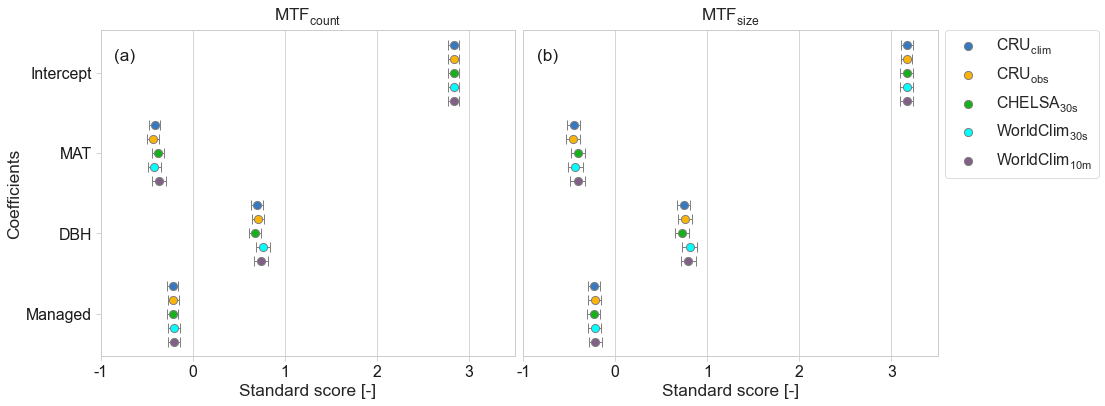

model       climate MTFcount                \
                                                          r2    AIC   RMSE   
0      MTF ~ MAT + DBH_mean + Managed       CRUclim     0.61  200.1  25.94   
1      MTF ~ MAT + DBH_mean + Managed     CRUNCEPv7     0.61  198.8  26.01   
2      MTF ~ MAT + DBH_mean + Managed     CHELSA30s     0.58  207.9  26.29   
3      MTF ~ MAT + DBH_mean + Managed  WorldClim30s     0.58  207.2  27.32   
4      MTF ~ MAT + DBH_mean + Managed  WorldClim10m     0.55  214.3  27.35   
5  MTF ~ MATsoil + DBH_mean + Managed     SoilTemps     0.62  196.5  26.84   

  MTFcmass                
        r2    AIC   RMSE  
0      0.6    221   43.9  
1      0.6  220.4  44.08  
2     0.57  228.7  43.31  
3     0.56  230.6  46.44  
4     0.54  234.2  45.38  
5     0.59  221.2  45.95

\begin{tabular}{lllllllll}
\toprule
{} &                               model &       climate & \multicolumn{3}{l}{MTFcount} & \multicolumn{3}{l}{MTFcmass} \\
{} &       r2 &    AIC &   RMSE &       r2 &    AIC &   RMSE \\
\midrule
0 &      MTF \textasciitilde  MAT + DBH\_mean + Managed &       CRUclim &     0.61 &  200.1 &  25.94 &      0.6 &    221 &   43.9 \\
1 &      MTF \textasciitilde  MAT + DBH\_mean + Managed &     CRUNCEPv7 &     0.61 &  198.8 &  26.01 &      0.6 &  220.4 &  44.08 \\
2 &      MTF \textasciitilde  MAT + DBH\_mean + Managed &     CHELSA30s &     0.58 &  207.9 &  26.29 &     0.57 &  228.7 &  43.31 \\
3 &      MTF \textasciitilde  MAT + DBH\_mean + Managed &  WorldClim30s &     0.58 &  207.2 &  27.32 &     0.56 &  230.6 &  46.44 \\
4 &      MTF \textasciitilde  MAT + DBH\_mean + Managed &  WorldClim10m &     0.55 &  214.3 &  27.35 &     0.54 &  234.2 &  45.38 \\
5 &  MTF \textasciitilde  MATsoil + DBH\_mean + Managed &     SoilTemps &     0.62 &  196.5 &  26.84 &  

In [52]:
excl_strs = ['Fire','WoodQ','Moisture']

if len([i for i in excl_strs if i in date_exp_str]) == 0:
    climate_data_plot  = {'CRUclim':'$CRU_{clim}$',
                          'CRUNCEPv7':'$CRU_{obs}$',
                          'CHELSA30s':'$CHELSA_{30s}$',
                          'WorldClim30s':'$WorldClim_{30s}$',
                          'WorldClim10m':'$WorldClim_{10m}$',
                          #'SoilTemps':'SoilTemps'
                         }

    # Define plot coefficient labels
    coeff_plot_dict = {'Humidity':'$Water_a$',
                       'Intercept':'Intercept',
                       'PFT':'PFT',
                       'DBH_mean':'DBH',
                       'Fire':'Fire',
                       'MATsoil':'Soil temperature',
                       'Managed':'Managed',
                       'MAP':'MAP',
                       'Soil_water':'Soil water saturation',
                       'Soil_water_max':'Maximum soil water saturation',
                       'MAT':'MAT',
                       'Wood_density':' Wood density',
                       'Wood_durability': 'Wood durability'}

    se_coef     = np.empty((len(climate_data_list),len(mtf_type)), dtype='object')
    plot_kws = {'linewidth':1,
                 'ecolor':'grey',
                 'capsize':5,
                 'dodge':0.7,
                 'scale':1.5,
                }


    df_clim_compare_count = pd.DataFrame()
    df_clim_compare_cmass = pd.DataFrame()

    mtf_type_plot = ['count','size']

    #if ('Fire' not in date_exp_str) | ('Insects' not in date_exp_str):
    clim_models = pd.concat(res_data[:,1,1,0],axis=0)
    clim_models.index.name = 'model'
    clim_models.reset_index(drop=False,inplace=True)
    display(clim_models[clim_models.model == unique_models_across_climates[0]])

    std_range    = np.arange(-3,3+1,0.1)
    line_styles  = ['--', '-']
    var_list_in = unique_models_across_climates[0].replace('MTF ~ ','').split(' + ')
    color_dict   = {var_list_in[v]:'C'+str(v) for v in range(len(var_list_in))}

    df_param_array = np.empty((len(climate_data_list),len(mtf_type),), dtype='object')

    print(len(climate_data_list))

    for c in range(len(climate_data_list)):
        var_list_reg = var_list_in # includes the spelling in the regression equations

        print(climate_data_list[c])


        for t in range(len(mtf_type)):

            if (c == 0): # CRU cli
                if t== 0:
                    idx_mod = 5
                elif t== 1:
                    idx_mod = 1

            elif (c == 1):
                if t== 0:
                    idx_mod = 6
                elif t== 1:
                    idx_mod = 1
            elif (c == 2): # Chelsa
                if t == 0:
                    idx_mod = 11
                else:
                    idx_mod = 9
            elif (c==3): # WC 30s
                if t == 0:
                    idx_mod = 10
                else:
                    idx_mod = 8
            elif (c==4):
                if t==0:
                    idx_mod = 11
                else:
                    idx_mod = 11


            df_param_array[c,t] = res_data[c,1,t,1][idx_mod].params.to_frame()
            #display(res_data[c,1,t,1][idx_mod].params.to_frame())

            se_coef[c,t]        = res_data[c,1,t,1][idx_mod].bse.to_frame()

            if t == 0:
                df_clim_compare_count = pd.concat([df_clim_compare_count, 
                                                   res_data[c,1,t,0].iloc[idx_mod].to_frame().T[['climate','r2','AIC','RMSE']]])
            elif t == 1:
                df_clim_compare_cmass = pd.concat([df_clim_compare_cmass, 
                                                   res_data[c,1,t,0].iloc[idx_mod].to_frame().T[['r2','AIC','RMSE']]])

            # Storing MATsoil as well
            if (t == 0) & (c == 4):
                idx_mod = 0
                df_clim_compare_count = pd.concat([df_clim_compare_count, 
                                                   res_data[c,1,t,0].iloc[idx_mod].to_frame().T[['climate','r2','AIC','RMSE']]])
            elif (t == 1) & (c == 4):
                idx_mod = 0
                df_clim_compare_cmass = pd.concat([df_clim_compare_cmass, 
                                                   res_data[c,1,t,0].iloc[idx_mod].to_frame().T[['climate','r2','AIC','RMSE']]])



    #--- Concat all mtf types and climates into 1 df in order to keep variables consistent across mtf types
    # Coefficients
    df1                     = pd.concat(df_param_array[:,0], axis=1)
    df2                     = pd.concat(df_param_array[:,1], axis=1)
    cols1                   = pd.MultiIndex.from_tuples(('count',i) for i in climate_data_plot)
    cols2                   = pd.MultiIndex.from_tuples(('cmass',i) for i in climate_data_plot)
    df1.columns             = cols1
    df2.columns             = cols2
    df_param_clim_mtf_types = pd.concat([df1,df2],axis=1)

    # Errors
    df1                     = pd.concat(se_coef[:,0],axis=1)
    df2                     = pd.concat(se_coef[:,1],axis=1)
    df1.columns             = cols1
    df2.columns             = cols2
    df_se_mtf_types         = pd.concat([df1,df2],axis=1)



    # Plot coefficients & errors
    sns.set_context("paper", font_scale=1.8)
    plt.rcParams['axes.titley']  = 1.01    # y is in axes-relative coordinates.

    # Add ticks to the white grid of seaborn
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left']   = True
    plt.rcParams['xtick.color']  = 'lightgrey'
    plt.rcParams['ytick.color']  = 'lightgrey'
    fig, ax= plt.subplots(1,2, figsize=(15,6), sharey=True)

    for t in range(len(mtf_type)):

        # Combine all 
        df_params_all_clims         = df_param_clim_mtf_types[mtf_type[t]]
        df_params_all_clims.columns = climate_data_list

        # Unstack df, to get format usable by sns.catplot
        df_params_all_clims_cat         = df_params_all_clims.unstack().reset_index().copy()
        df_params_all_clims_cat.columns = ['Climate', 'Coefficient', 'Value']
        df_params_all_clims_cat.Climate = df_params_all_clims_cat.Climate.apply(lambda x: climate_data_plot[x])
        #print(len(df_params_all_clims_cat ))


        # Get plot labels from dict based on unique significnat coeffs included in this experiment
        coeffs_unique_ex = df_params_all_clims_cat.Coefficient.unique().tolist()
        plot_labels      = [coeff_plot_dict[i] for i in coeffs_unique_ex]



        # Get coefficient errors
        se_mtf_type_ex         = df_se_mtf_types[mtf_type[t]]
        se_mtf_type_ex.columns = climate_data_list
        # Remove mask from data - because plt.errorbar() ignores the mask
        se_mtf_masked   = se_mtf_type_ex.unstack().tolist() # !! No transposing !!
        point_mask      = [1 if pd.notnull(i) else 0 for i in se_mtf_masked]
        se_mtf_unmasked = [i for i in se_mtf_masked if pd.notnull(i)]



        g = sns.pointplot(data=df_params_all_clims_cat, 
                          hue='Climate', 
                          x='Value', 
                          y='Coefficient',
                          linestyles='None',
                          dodge=plot_kws['dodge'],
                          ax=ax[t],
                          scale=plot_kws['scale']
                         )
        g.legend_.remove() # Remove subplot legends


        ax[t].set_xlabel("Standard score [-]")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax[t].set_xticklabels(np.arange(-1,5), color='k')

        if t == 0:
            ax[t].set_ylabel("Coefficients")
        else:
            ax[t].set_ylabel("")
        ax[t].set_title('MTF$_{'+mtf_type_plot[t]+'}$')
        ax[t].set_yticklabels(plot_labels, color='k')
        ax[t].set_xlim(-1, 3.5)


        # Find the x,y coordinates for each point
        x_coords = np.empty((len(se_mtf_masked),))
        y_coords = np.empty((len(se_mtf_masked),))
        colors = []

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            i = 0
            for point_pair in g.collections:
                point_pair.set_edgecolor(plot_kws['ecolor'])
                point_pair.set_linewidth(plot_kws['linewidth'])
                colors.append(point_pair.get_facecolors())
                for x, y in point_pair.get_offsets():
                    x_coords[i] = x
                    y_coords[i] = y
                    i += 1
            x_coords = x_coords[~np.isnan(x_coords)]
            y_coords = y_coords[~np.isnan(y_coords)]      

        # Plot errobars for each point
        ax[t].errorbar(x_coords, y_coords, 
                       xerr=se_mtf_unmasked,
                       ecolor=plot_kws['ecolor'], 
                       elinewidth=plot_kws['linewidth'], 
                       capsize=plot_kws['capsize'],
                       fmt=' ', 
                       zorder=-1, )



    ax[t].legend(bbox_to_anchor=(1,1.025),loc='upper left')
    ax[0].annotate(xy=(-0.85,-0.15),text='(a)',color='k')
    ax[1].annotate(xy=(-0.85,-0.15),text='(b)',color='k')
    ax[1].yaxis.set_ticks_position('none') # Remove ticks only from 2nd plot sharing the yaxis with 1st
    plt.subplots_adjust(wspace=0.02)
    plt.savefig('Appendix_FigureB2_climate_comparison.png', dpi=300, bbox_inches='tight')
    plt.show() 


    # Display best models by climate
    df_clim_compare_count.index.name = 'model'
    df_clim_compare_cmass.index.name = 'model'
    df_clim_compare_count.iloc[-1,0] = 'SoilTemps'
    #f_clim_compare_cmass.iloc[-1,0] = 'SoilTemps'
    df_clim_compare_count.reset_index(drop=False,inplace=True)
    df_clim_compare_cmass.reset_index(drop=False,inplace=True)
    df_clim_compare_count.set_index(['model','climate'],inplace=True)
    df_clim_compare_cmass.set_index(['model','climate'],inplace=True)
    df_clim_compare_cmass.index = df_clim_compare_count.index

    df_clim_compare_count.columns = pd.MultiIndex.from_tuples([('MTFcount',i) for i in df_clim_compare_count.columns])
    df_clim_compare_cmass.columns = pd.MultiIndex.from_tuples([('MTFcmass',i) for i in df_clim_compare_cmass.columns])
    clim_comparison_best = pd.concat([df_clim_compare_count, df_clim_compare_cmass],axis=1)
    clim_comparison_best.reset_index(drop=False, inplace=True)

    clim_comparison_best.model = clim_comparison_best.model
    display(clim_comparison_best)
    print(clim_comparison_best.to_latex())
    with open('spe_reg_results/'+date_exp_str+'_best_model_climate_'+str(remove_data)+'_'+str(alpha)+'_species.pkl','wb') as f:
        pickle.dump(clim_comparison_best,f)